# Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import car and non-car images

##### Cell #1

In [ ]:
import glob
import pickle
import csv
from sklearn.utils import shuffle as Shuffle
%matplotlib inline 

# Read in cars and notcars
cars = []
images = glob.glob('vehicles/*/*.png')
for image in images:
    cars.append(image)
Shuffle(cars)

notcars = []
images = glob.glob('non-vehicles/*/*.png')
for image in images:
    notcars.append(image)
Shuffle(notcars)

udacity_cars = []
with open('./object-detection-crowdai/labels.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if 'Car' in line[5]:
            car_dict = { "file": line[4], "bbox": ((int(line[0]),int(line[1])), (int(line[2]),int(line[3]))) }
            udacity_cars.append(car_dict)
Shuffle(udacity_cars)

# Saving classifier to pickle file
pickle_carpics = { "cars" : cars, "notcars" : notcars, "udacity_cars" : udacity_cars }
with open('carpics.p', 'wb') as pf:
    pickle.dump(pickle_carpics, pf)
    print('pickle file saved successfully!')
    pf.close()

#### Display example car and non-car images

##### Cell #2

In [ ]:
import os
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

rand_car = np.random.randint(0, len(cars))
rand_notcar = np.random.randint(0, len(notcars))
rand_udacity_car = np.random.randint(0, len(udacity_cars))

rand_car = mpimg.imread(cars[rand_car])
rand_notcar = mpimg.imread(notcars[rand_notcar])
filename = os.path.join('.', 'object-detection-crowdai', udacity_cars[rand_udacity_car]["file"])
rand_udacity_car_image = mpimg.imread(filename)

bbox = udacity_cars[rand_udacity_car]["bbox"]
rand_udacity_car_image = rand_udacity_car_image[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]

plt.figure()
plt.imshow(rand_car)
plt.figure()
plt.imshow(rand_notcar)
plt.figure()
plt.imshow(rand_udacity_car_image)

## Define image processing pipeline

##### Cell #3

In [1]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif conv is not 'RGB':
        print('Invalid color space')
    return img

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Define feature extraction function

##### Cell #4

In [2]:
import matplotlib.image as mpimg
import cv2

def extract_features(imgs, w_bboxes=False, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        if w_bboxes:
            
            bbox = file["bbox"]
            min_bbox_size = min( bbox[1][1]-bbox[0][1], bbox[1][0]-bbox[0][0] )
            max_bbox_size = max( bbox[1][1]-bbox[0][1], bbox[1][0]-bbox[0][0] )
            
            # check if bounding boxes indeces are ok
            if min_bbox_size is 0 or max_bbox_size is 0:
                continue
            # calculate bounding box aspect ratio
            bbox_aratio = max_bbox_size / min_bbox_size
            # if aspect ratio is not adequate or if bounding box is too small, skip image
            if min_bbox_size >= 64 and bbox_aratio < 2.5:
                image = mpimg.imread(os.path.join('.', 'object-detection-crowdai', file["file"]))
                image = image[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]]
                # if bounding box is too far from square shape, crop square shape out of it
                if bbox_aratio > 1.2:
                    image = image[0:min_bbox_size, 0:min_bbox_size]
                
                # resize image to standard 64-by-64 image
                image_0 = cv2.resize(image[:,:,0], (64,64))
                image_1 = cv2.resize(image[:,:,1], (64,64))
                image_2 = cv2.resize(image[:,:,2], (64,64))
                image = np.dstack((image_0, image_1, image_2))
            else:
                continue
        else:  
            image = mpimg.imread(file)
        
        # scaling to [0, 1] range in case range was initially [0, 255] to enforce consistency
        if (np.max(image) > 1.0):
            image = image.astype(np.float32)/255
        else:
            image = image.astype(np.float32)
            
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(np.copy(image), conv=color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Train a classifier with car and non-car images

#### Global training parameters

##### Cell #5

In [3]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
extract_spatial_features = True # Spatial features on or off
extract_hist_bins_features = True # Histogram features on or off
extract_hog_features = True # HOG features on or off

#### Extract features

##### Cell #6

In [ ]:
import os
import pickle

# Restore previously saved classifier and scaler
if os.path.isfile('carpics.p'):
    with open('carpics.p', 'rb') as pf:
        pickle_carpics = pickle.load(pf)
        cars = pickle_carpics["cars"]
        notcars = pickle_carpics["notcars"]
        udacity_cars = pickle_carpics["udacity_cars"]
        print('pickle file restored successfully!')
        pf.close()

car_features = extract_features(cars, w_bboxes=False, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=extract_spatial_features, 
                        hist_feat=extract_hist_bins_features, hog_feat=extract_hog_features)
notcar_features = extract_features(notcars, w_bboxes=False, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=extract_spatial_features, 
                        hist_feat=extract_hist_bins_features, hog_feat=extract_hog_features)
#udacity_cars_features = extract_features(udacity_cars, w_bboxes=True, color_space=color_space, 
#                        spatial_size=spatial_size, hist_bins=hist_bins, 
#                        orient=orient, pix_per_cell=pix_per_cell, 
#                        cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel, spatial_feat=extract_spatial_features, 
#                        hist_feat=extract_hist_bins_features, hog_feat=extract_hog_features)

# Saving classifier to pickle file
pickle_features = { "car_features" : car_features, "notcar_features" : notcar_features, \
                    "udacity_cars_features" : udacity_cars_features }
with open('features.' + color_space.lower() + '.p', 'wb') as pf:
    pickle.dump(pickle_features, pf)
    print('pickle file saved successfully!')
    pf.close()

#### Generate images for write-up

##### Cell #7

In [ ]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pickle
%matplotlib inline

if os.path.isfile('carpics.p'):
    with open('carpics.p', 'rb') as pf:
        pickle_carpics = pickle.load(pf)
        cars = pickle_carpics["cars"]
        notcars = pickle_carpics["notcars"]
        udacity_cars = pickle_carpics["udacity_cars"]
        print('pickle file restored successfully!')
        pf.close()

car_img = mpimg.imread(cars[100])
notcar_img = mpimg.imread(notcars[100])
udacity_cars_img = mpimg.imread('object-detection-crowdai/' + udacity_cars[0]["file"])
udacity_cars_cvt = convert_color(udacity_cars_img, conv='HLS')

car_img_cvt = convert_color(car_img, conv='HSV')
notcar_img_cvt = convert_color(notcar_img, conv='HSV')
car_img_features, car_img_hog_image = hog(car_img[:,:,0], orientations=orient, 
                                          pixels_per_cell=(pix_per_cell, pix_per_cell),
                                          cells_per_block=(cell_per_block, cell_per_block), 
                                          transform_sqrt=False, 
                                          visualise=True, feature_vector=True)
notcar_img_features, notcar_img_hog_image = hog(notcar_img[:,:,0], orientations=orient, 
                                                pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                cells_per_block=(cell_per_block, cell_per_block), 
                                                transform_sqrt=False, 
                                                visualise=True, feature_vector=True)
plt.figure()
plt.imshow(car_img_cvt)
plt.figure()
plt.imshow(notcar_img_cvt)
plt.figure()
plt.imshow(udacity_cars_cvt)
plt.figure()
plt.imshow(car_img_hog_image)
plt.figure()
plt.imshow(notcar_img_hog_image)

In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

test6_image = mpimg.imread('./test_images/test6.jpg')
plt.figure()
plt.imshow(test6_image)
test2_image = mpimg.imread('./test_images/test2.jpg')
plt.figure()
plt.imshow(test2_image)
test4_image = mpimg.imread('./test_images/test4.jpg')
plt.figure()
plt.imshow(test4_image)

#### Train classifier

##### Cell #8

In [ ]:
import time
import os
import pickle
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Restore previously saved classifier and scaler
if os.path.isfile('features.' + color_space.lower() + '.p'):
    with open('features.' + color_space.lower() + '.p', 'rb') as pf:
        pickle_features = pickle.load(pf)
        car_features = pickle_features["car_features"]
        notcar_features = pickle_features["notcar_features"]
        udacity_cars_features = pickle_features["udacity_cars_features"]
        print('pickle file restored successfully!')
        pf.close()
        
udacity_cars_features = udacity_cars_features[0:int(len(udacity_cars_features)/3)]
        
# flags for enabling training with various classifiers
fancy_training = False
grid_search_training = False

#X = np.vstack((car_features, notcar_features, udacity_cars_features)).astype(np.float64)
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
#y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)), np.ones(len(udacity_cars_features))))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

if fancy_training:
    # enable grid search
    if grid_search_training:
        svr = SVC()
        # try radial basis function, polynomial, various C and gamma values
        search_parameters = { 'kernel': ('rbf', 'poly'), \
                              'C' : np.logspace(-1,1,3), \
                              'gamma': np.logspace(-7,1,3) }
        clf = GridSearchCV(svr, search_parameters, scoring='accuracy', verbose=10)
    else:
        # Use a radial basis function
        clf = SVC(kernel='rbf')
else:
    # Use a linear SVC
    clf = LinearSVC()


# Check the training time
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train classifer...')

# Check the score of the classifier
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))

# Saving classifier to pickle file
pickle_clf = { "clf" : clf, "X_scaler" : X_scaler }
with open('clf_scaler.' + color_space.lower() + '.p', 'wb') as pf:
    pickle.dump(pickle_clf, pf)
    print('pickle file saved successfully!')
    pf.close()

## Define window search function

#### Window search

##### Cell #9

In [4]:
import numpy as np

def search_window(img, ystart, ystop, scale, clf, X_scaler, window, orient, pix_per_cell, \
                  cell_per_block, hog_channel, color_space, spatial_size, hist_bins, \
                  spatial_feat=True, hist_feat=True, hog_feat=True, output_img=False):
    
    Debug = False
    draw_img = np.copy(img)
    if (np.max(img) > 1.0):
        img = img.astype(np.float32)/255
    else:
        img = img.astype(np.float32)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps.
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    if Debug:
        print("\n\nscale {}".format(scale))
        print("ch1.shape {}".format(ch1.shape))
    
    # window steps
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # Instead of overlap, define how many cells to step
    cells_per_step_x = 2
    cells_per_step_y = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step_x + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step_y + 1
    if Debug:
        print("nysteps {}".format(nysteps))
    
    bboxes = []
    
    # Compute individual channel HOG features for the entire image
    if hog_feat:
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step_x
                xpos = xb*cells_per_step_y
                
                # Extract HOG for this patch
                if hog_channel is 0:
                    hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                elif hog_channel is 1:
                    hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                elif hog_channel is 2:
                    hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                elif hog_channel is "ALL":
                    hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
                # Get color features
                if spatial_feat:
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                if hist_feat:
                    hist_features = color_hist(subimg, nbins=hist_bins)
                
                # Scale features and make a prediction
                feature_vec = []
                if spatial_feat:
                    feature_vec.append(spatial_features)
                if hist_feat:
                    feature_vec.append(hist_features)
                if hog_feat:
                    feature_vec.append(hog_features)
                
                features = np.concatenate(feature_vec).astype(np.float64)
                if Debug:
                    print("hog_features {}".format(len(hog_features)))
                    print("hist_features {}".format(len(hist_features)))
                    print("spatial_features {}".format(len(spatial_features)))
                test_features = X_scaler.transform(features.reshape(1, -1)) 
                test_prediction = clf.predict(test_features)
            
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    x1_y1 = (xbox_left, ytop_draw+ystart)
                    x2_y2 = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                    bboxes.append((x1_y1, x2_y2))
                    if output_img:
                        cv2.rectangle(draw_img, x1_y1, x2_y2, (0,0,255), 6)
    
    if output_img:
        return bboxes, draw_img
    else:
        return bboxes

#### Search region of interest

##### Cell #10

In [5]:
def search_roi(input_image, y_array, scaling_factors, clf, X_scaler, win_size, orient, \
                                                              pix_per_cell, cell_per_block, \
                                                              hog_channel, color_space, spatial_size, hist_bins, \
                                                              spatial_feat, hist_feat, hog_feat, output_img=False):
    bboxes_list = []
    assert(len(y_array)==len(scaling_factors))
    
    for y_start_stop, scale in zip(y_array, scaling_factors):
            
        if output_img:
            bboxes, input_image = search_window(input_image, y_start_stop[0], y_start_stop[1], scale, \
                                             clf, X_scaler, win_size, orient, pix_per_cell, cell_per_block, \
                                             hog_channel, color_space, spatial_size, hist_bins, \
                                             spatial_feat, hist_feat, hog_feat, output_img)
        else:
            bboxes = search_window(input_image, y_start_stop[0], y_start_stop[1], scale, \
                                             clf, X_scaler, win_size, orient, pix_per_cell, cell_per_block, \
                                             hog_channel, color_space, spatial_size, hist_bins, \
                                             spatial_feat, hist_feat, hog_feat, output_img)
        bboxes_list.extend(bboxes)
    
    if output_img:
        return bboxes_list, input_image
    else:
        return bboxes_list

#### Global search parameters

##### Cell #11

In [6]:
y_array = [(400, 480), (400, 600), (400, 630), (450, 720)]
# different scaling steps applied along y axis
scaling_factors = [1.1, 1.5, 2.0, 2.5]
win_size = 64

#### Search test images

##### Cell #12

In [10]:
import os
import glob
import pickle
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

# Restore previously saved classifier and scaler
if os.path.isfile('clf_scaler.' + color_space.lower() + '.p'):
    with open('clf_scaler.' + color_space.lower() + '.p', 'rb') as pf:
        pickle_clf = pickle.load(pf)
        clf = pickle_clf["clf"]
        X_scaler = pickle_clf["X_scaler"]
        print('pickle file restored successfully!')
        pf.close()

# test images
test_images = glob.glob('test_images/*.jpg')
test_bboxes = []

for test_img in test_images:

    # load test image
    test_img = mpimg.imread(test_img)
    
    # search ROI in image and output both bounding boxes and image with bounding boxes drawn upon them for debugging
    bboxes, test_img = search_roi(test_img, y_array, scaling_factors, clf, X_scaler, win_size, orient, \
                                  pix_per_cell, cell_per_block, hog_channel, color_space, spatial_size, hist_bins, \
                                  spatial_feat=extract_spatial_features, hist_feat=extract_hist_bins_features, \
                                  hog_feat=extract_hog_features, output_img=True)
    
    test_bboxes.append(bboxes)

    plt.figure()
    plt.imshow(test_img)

pickle file restored successfully!


/home/olivieri/Apps/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Generate heat images

#### Heat functions

##### Cell #13

In [7]:
import numpy as np
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
    # Return the image
    return bboxes

#### The final detection pipeline

##### Cell #14

In [8]:
from collections import deque

boxhistory = deque([])
boxhistory_length = 10

def detection_pipeline(input_image):
    
    global scaling_factors, clf, X_scaler, win_size, orient, pix_per_cell, cell_per_block, \
           hog_channel, spatial_size, hist_bins, extract_spatial_features, extract_hist_bins_features, \
           extract_hog_features, boxhistoryList, Debug
    
    # generate empty heat map
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    
    # find bounding boxes
    bboxes = search_roi(input_image, y_array, scaling_factors, clf, X_scaler, win_size, orient, \
                        pix_per_cell, cell_per_block, hog_channel, color_space, spatial_size, hist_bins, \
                        spatial_feat=extract_spatial_features, hist_feat=extract_hist_bins_features, \
                        hog_feat=extract_hog_features, output_img=False)
    
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    
    # debug dict for storing intermediate pipeline stages
    returned_debug = {}
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    if Debug:
        returned_debug["heat"] = np.copy(heat)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    if Debug:
        returned_debug["labels"] = np.copy(labels)
    bboxes_labeled = draw_labeled_bboxes(np.copy(input_image), labels)
    debug_drawn_boxes = np.copy(input_image)
    for bbox in bboxes_labeled:
        cv2.rectangle(debug_drawn_boxes, bbox[0], bbox[1], (0,0,255), 6)
    if Debug:
        returned_debug["debug_drawn_boxes"] = debug_drawn_boxes
    
    if len(boxhistory) >= boxhistory_length:
        boxhistory.popleft()
    boxhistory.append(bboxes_labeled)
    
    heat = np.zeros_like(input_image[:,:,0]).astype(np.float)
    for bboxes in boxhistory:
        heat = add_heat(heat, bboxes)
    
    heat = apply_threshold(heat,2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    bboxes_labeled = draw_labeled_bboxes(np.copy(input_image), labels)
    
    # Draw the box on the image
    output_img = np.copy(input_image)
    for bbox in bboxes_labeled:
        cv2.rectangle(output_img, bbox[0], bbox[1], (0,0,255), 6)
    
    if Debug:
        return output_img, returned_debug
    else:
        return output_img

#### Apply entire pipeline on test images results

##### Cell #15

/home/olivieri/Apps/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


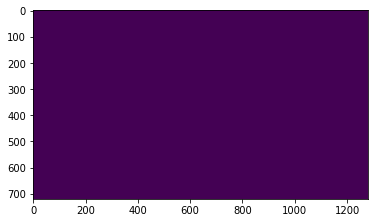

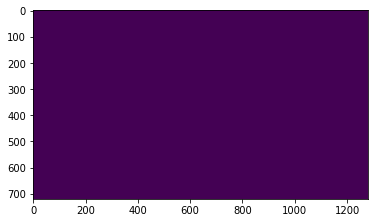

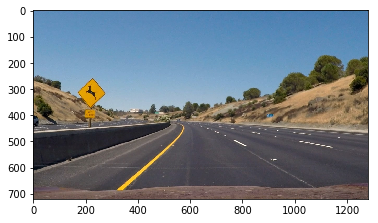

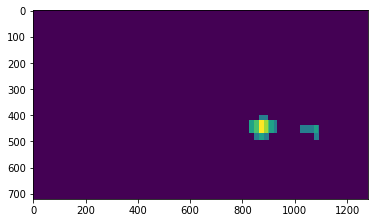

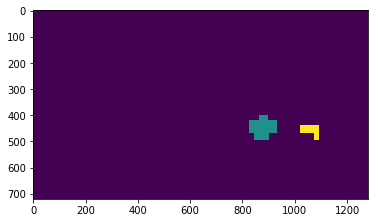

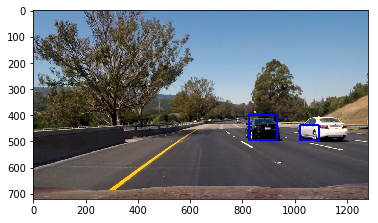

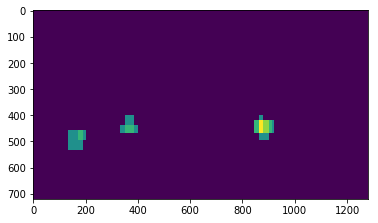

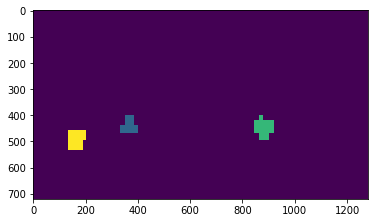

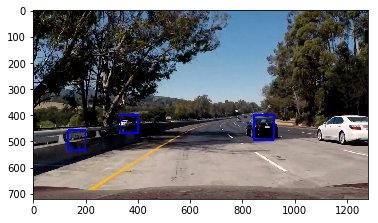

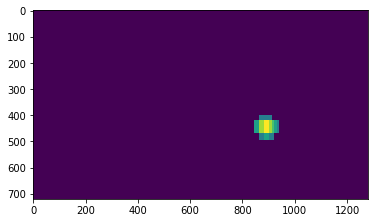

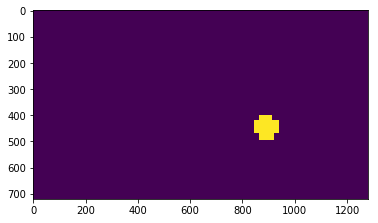

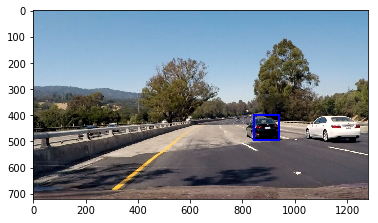

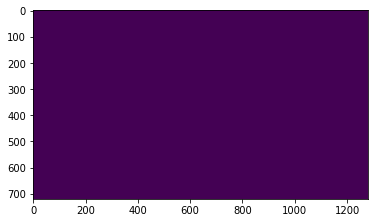

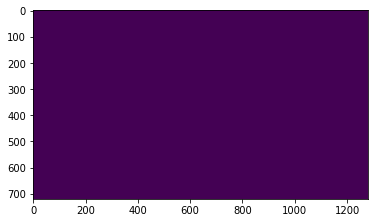

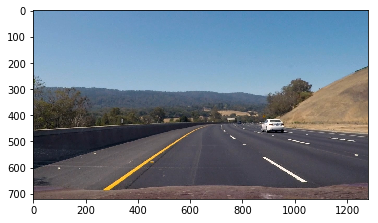

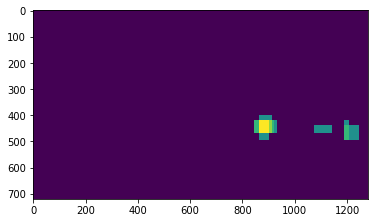

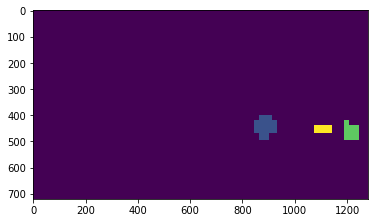

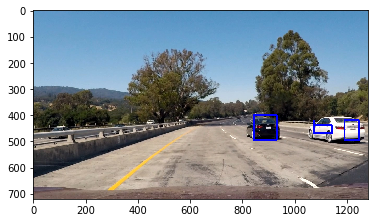

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Debug = True

if len(test_images) is not len(test_bboxes):
    print("Error: number of bboxes doesn't match number of test images")
else:
    for img_idx in range(len(test_images)):

        test_img = mpimg.imread(test_images[img_idx])
        if Debug:
            draw_img, debug = detection_pipeline(test_img)

        if Debug:
            plt.figure()
            plt.imshow(debug["heat"])
            if [len(debug["labels"]) > 0]:
                plt.figure()
                plt.imshow(debug["labels"][0])
            plt.figure()
            plt.imshow(debug["debug_drawn_boxes"])

## Apply vehicle detection on video

##### Cell #16

In [9]:
# Import everything needed to edit/save/watch video clips
import os
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.pyplot as plt
%matplotlib qt

# Restore previously saved classifier and scaler
if os.path.isfile('clf_scaler.' + color_space.lower() + '.p'):
    with open('clf_scaler.' + color_space.lower() + '.p', 'rb') as pf:
        pickle_clf = pickle.load(pf)
        clf = pickle_clf["clf"]
        X_scaler = pickle_clf["X_scaler"]
        print('pickle file restored successfully!')
        pf.close()
        
Debug = False

video_output_file = 'project_video_out.mp4'
video_input = VideoFileClip("../P04-AdvancedLaneFinding/project_video.mp4")
#video_input = video_input.subclip(6, 14)
    
# For debugging purposes, some stages of the pipeline stages can be outputted while
# running the lane finding on the video frames
if not Debug:
    video_output = video_input.fl_image(detection_pipeline)
    %time video_output.write_videofile(video_output_file, audio=False)
else:
    for t in np.linspace(30, 34, 10):
        image = video_input.get_frame(t)
        print('\ntime {}'.format(t))
        found_cars = detection_pipeline(image)
        #found_cars = image
        plt.figure(figsize=(15,15))
        plt.imshow(found_cars)

pickle file restored successfully!
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [13:03<00:00,  1.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 14min 55s, sys: 27.2 s, total: 15min 22s
Wall time: 13min 4s
